In [69]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters



In [70]:
column_names = ['user_id', 'activity', 'timestamp', 'x_axis', 'y_axis', 'z_axis']

df = pd.read_csv('c:/Users/asus/WISDM_ar_v1.1_raw.txt', header=None, names=column_names)
df.z_axis.replace(regex=True, inplace=True, to_replace=r';', value=r'')
df['z_axis'] = df.z_axis.astype(np.float64)
df.dropna(axis=0, how='any', inplace=True)

In [71]:
df.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [72]:
df.shape
Walking = df[df['activity']=='Walking'].head(48395).copy()
Jogging = df[df['activity']=='Jogging'].head(48395).copy()
Upstairs = df[df['activity']=='Upstairs'].head(48395).copy()
Downstairs = df[df['activity']=='Downstairs'].head(48395).copy()
Sitting = df[df['activity']=='Sitting'].head(48395).copy()
Standing = df[df['activity']=='Standing'].copy()
balanced_data = pd.DataFrame()
balanced_data = balanced_data.append([Walking, Jogging, Upstairs, Downstairs, Sitting, Standing])
balanced_data.shape
df=balanced_data

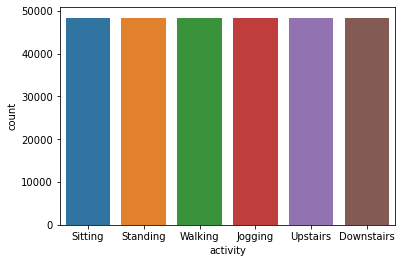

In [73]:
sns.countplot(x = 'activity',
              data = df,
              order = df.activity.value_counts().index);


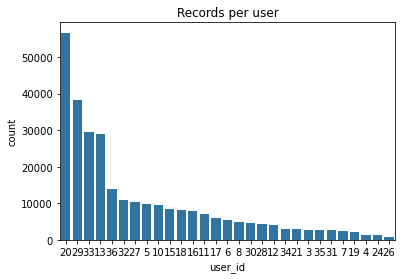

In [74]:
sns.countplot(x = 'user_id',
              data = df,
              palette=[sns.color_palette()[0]],
              order = df.user_id.value_counts().index);
plt.title("Records per user");

In [75]:
def plot_activity(activity, df):
    data = df[df['activity'] == activity][['x_axis', 'y_axis', 'z_axis']][:200]
    axis = data.plot(subplots=True, figsize=(16, 12), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

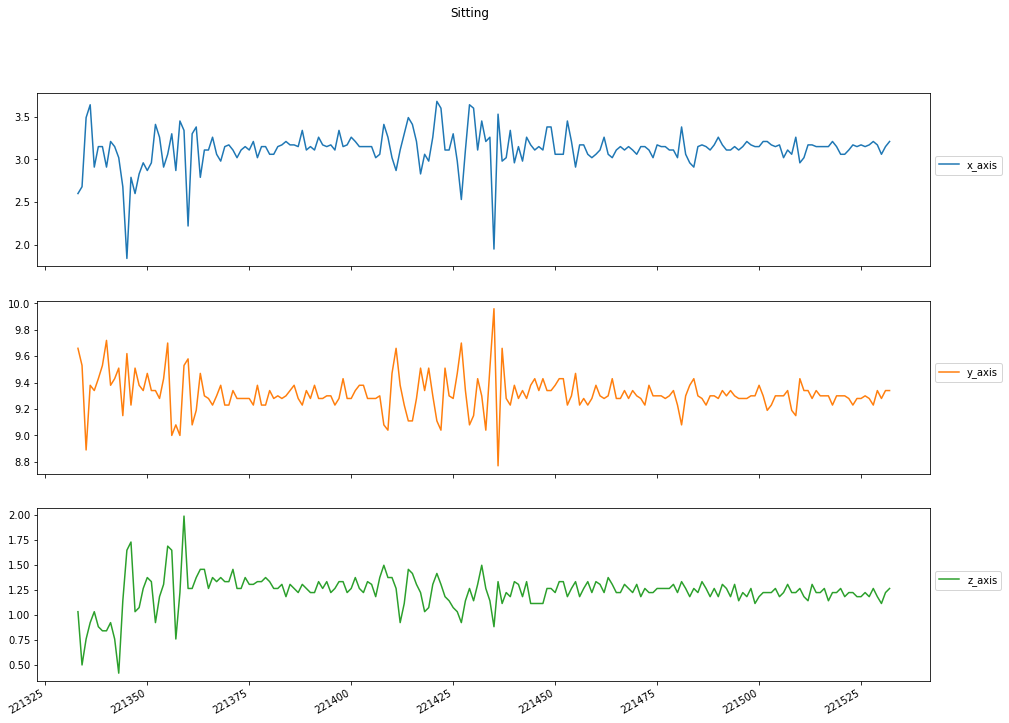

In [76]:
plot_activity("Sitting", df);

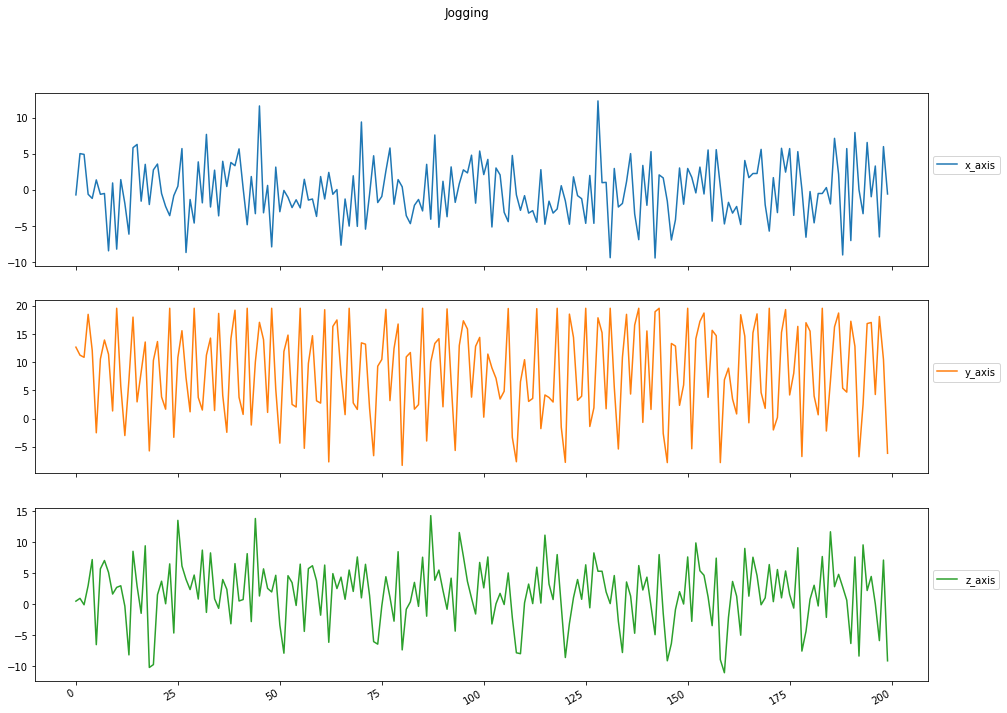

In [77]:
plot_activity("Jogging", df);

In [78]:
df_train = df[df['user_id'] <= 30]
df_test = df[df['user_id'] > 30]

In [79]:
from sklearn.preprocessing import RobustScaler

scale_columns = ['x_axis', 'y_axis', 'z_axis']

scaler = RobustScaler()

scaler = scaler.fit(df_train[scale_columns])

df_train.loc[:, scale_columns] = scaler.transform(df_train[scale_columns].to_numpy())
df_test.loc[:, scale_columns] = scaler.transform(df_test[scale_columns].to_numpy())
df_test

C:\Users\asus\anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
C:\Users\asus\anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


,user_id,activity,timestamp,x_axis,y_axis,z_axis
597,33,Walking,49394992294000,0.129570,-0.042183,0.393918
598,33,Walking,49395102310000,0.175740,0.053138,0.590878
599,33,Walking,49395202316000,-0.098975,1.302906,0.099829
600,33,Walking,49395302292000,0.799044,0.385704,-0.393918
601,33,Walking,49395412338000,-0.020485,0.148460,-0.296788
...,...,...,...,...,...,...
832892,31,Standing,25207361641000,1.376271,-0.584759,-0.129473
832893,31,Standing,25207401497000,1.505085,-0.662519,0.130027
832894,31,Standing,25207441536000,1.337288,-0.548989,-0.038351
832895,31,Standing,25207521553000,1.344068,-0.542768,-0.022503


In [92]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 200
STEP = 5

X_train, y_train = create_dataset(
    df_train[['x_axis', 'y_axis', 'z_axis']], 
    df_train.activity, 
    TIME_STEPS, 
    STEP
)

X_test, y_test = create_dataset(
    df_test[['x_axis', 'y_axis', 'z_axis']], 
    df_test.activity, 
    TIME_STEPS, 
    STEP
)

In [93]:
print(X_train.shape, y_train.shape)

(45521, 200, 3) (45521, 1)


In [94]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

In [95]:
print(X_train.shape, y_train.shape)

(45521, 200, 3) (45521, 6)


In [96]:

model = keras.Sequential()
model.add(
      keras.layers.Bidirectional( keras.layers.LSTM(
          units=128,
          input_shape=[X_train.shape[1], X_train.shape[2]]
      )
    
))
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['acc']
)

In [97]:
history=model.fit( X_train, y_train,epochs =10,batch_size=32)


Epoch 1/10
1423/1423 [==============================] - 342s 238ms/step - loss: 0.6103 - acc: 0.7615
Epoch 2/10
1423/1423 [==============================] - 339s 238ms/step - loss: 0.3073 - acc: 0.8770
Epoch 3/10
1423/1423 [==============================] - 340s 239ms/step - loss: 0.2910 - acc: 0.8907
Epoch 4/10
1423/1423 [==============================] - 335s 235ms/step - loss: 0.1743 - acc: 0.9381
Epoch 5/10
1423/1423 [==============================] - 342s 240ms/step - loss: 0.1197 - acc: 0.9578
Epoch 6/10
1423/1423 [==============================] - 344s 241ms/step - loss: 0.0691 - acc: 0.9781
Epoch 7/10
1423/1423 [==============================] - 342s 240ms/step - loss: 0.0742 - acc: 0.9767
Epoch 8/10
1423/1423 [==============================] - 340s 239ms/step - loss: 0.0798 - acc: 0.9738
Epoch 9/10
1423/1423 [==============================] - 341s 240ms/step - loss: 0.0457 - acc: 0.9846
Epoch 10/10
1423/1423 [==============================] - 339s 239ms/step - loss: 0.0508 - a

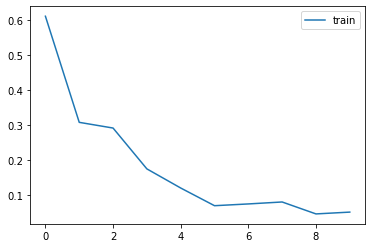

In [98]:
plt.plot(history.history['loss'], label='train')
plt.legend();

In [99]:
model.evaluate(X_test, y_test)

390/390 [==============================] - 54s 135ms/step - loss: 1.9903 - acc: 0.7163


[1.9902746677398682, 0.7162671089172363]

In [100]:
y_pred = model.predict(X_test)


In [101]:
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, class_names):
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(18, 16)) 
  ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(220, 20, n=7),
      ax=ax
  )

  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  ax.set_xticklabels(class_names)
  ax.set_yticklabels(class_names)
  b, t = plt.ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show() # ta-da!

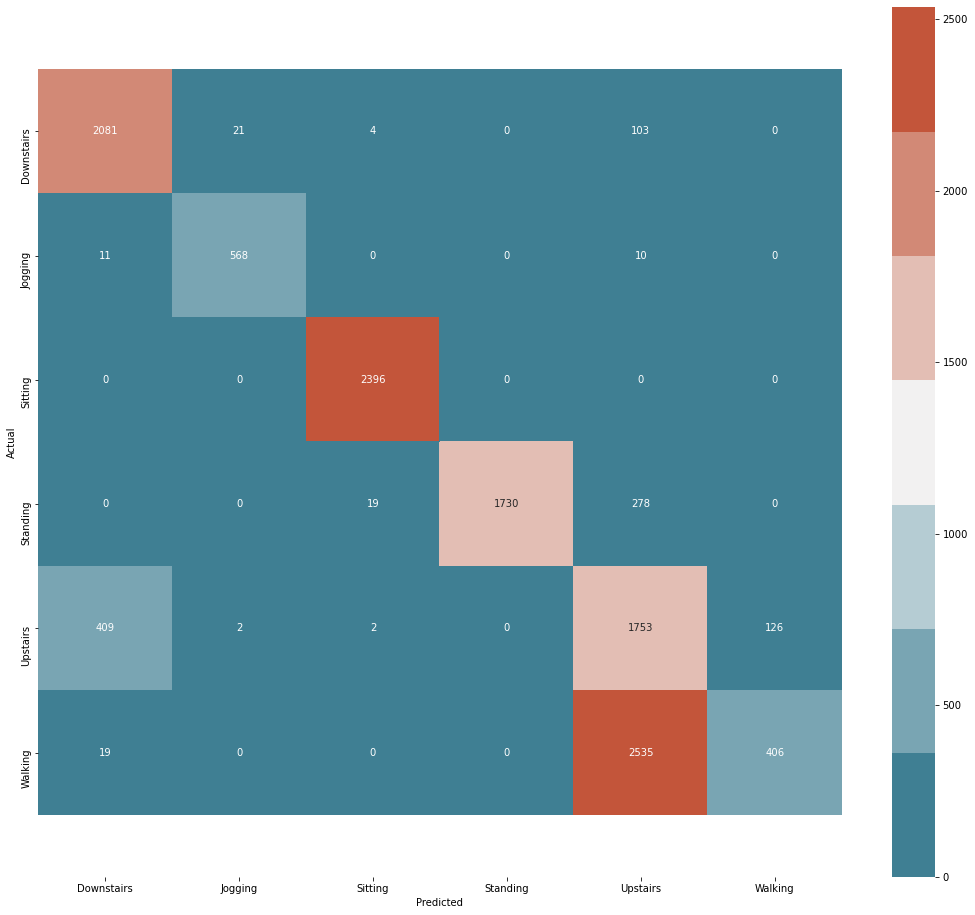

In [102]:
plot_cm(
  enc.inverse_transform(y_test),
  enc.inverse_transform(y_pred),
  enc.categories_[0]
)